In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


**data reading**

In [4]:
train = pd.read_csv("data/train.csv", sep=';', low_memory=False)

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32428 entries, 0 to 32427
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   customernumber        32428 non-null  int64 
 1   date                  32428 non-null  object
 2   salutation            32428 non-null  int64 
 3   title                 32428 non-null  int64 
 4   domain                32428 non-null  int64 
 5   datecreated           32428 non-null  object
 6   newsletter            32428 non-null  int64 
 7   model                 32428 non-null  int64 
 8   paymenttype           32428 non-null  int64 
 9   deliverytype          32428 non-null  int64 
 10  invoicepostcode       32428 non-null  int64 
 11  delivpostcode         1392 non-null   object
 12  voucher               32428 non-null  int64 
 13  advertisingdatacode   6523 non-null   object
 14  case                  32428 non-null  int64 
 15  numberitems           32428 non-null

**Data pre-processing**

The customernumber is a unique identifier and usually does not carry a predictive value.
Date of first order and date of account creation and date of promised delivery and date of actual delivery: these characteristics are less related to the target variable.
Therefore delete these features


In [40]:
train = train.drop(['customernumber', 'date', 'datecreated', 'deliverydatepromised', 'deliverydatereal'], axis=1)

There are a large number of missing values in the delivpostcode and advertisingdatacode columns, and invoicepostcode is too categorized to be interpreted, so it is deleted.

In [41]:
train = train.drop([ 'delivpostcode', 'advertisingdatacode', 'invoicepostcode'], axis=1)

'salutation', 'domain', 'paymenttype', 'deliverytype', 'case' are all categorical variables, so dummy variables need to be introduced

In [42]:
train = pd.get_dummies(train, columns=['salutation', 'domain', 'paymenttype', 'case'])

In [43]:
# Data set splitting
X = train.drop('target90', axis=1)
y = train['target90']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=71)
y_train.value_counts()

target90
0    21121
1     4821
Name: count, dtype: int64

**Model training and hyperparameter optimization**

With a sample size of 21121 for target90 of 0 and 4821 for 1, the dataset is unbalanced. class_weight='balanced increases the weight of the minority category and decreases the weight of the majority category to help the model learn the minority category more efficiently (i.e., the case where target90 is 1).

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score

rf = RandomForestClassifier(class_weight='balanced', random_state=71)

max_depth = list(range(0,30)) + [None]
min_samples_split = range(5,20)
min_samples_leaf = range(5,20)
n_estimators = range(10,200)
max_features = range(3,8)
param_dist = {'max_depth': max_depth,'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'n_estimators': n_estimators, 'max_features':max_features}

def precision_class_0(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=0)
def recall_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)

random_search = RandomizedSearchCV(rf, param_dist, cv=10, n_jobs=-1, verbose=1, n_iter=100, scoring=make_scorer(precision_class_0))

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_accuracy = random_search.best_score_
best_params, best_accuracy

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


({'n_estimators': 173,
  'min_samples_split': 9,
  'min_samples_leaf': 18,
  'max_features': 3,
  'max_depth': 10},
 0.8591992263434116)

In [44]:
# The best parameters after a random search are used to train the model
model_rf= RandomForestClassifier(class_weight='balanced',  random_state=71,max_depth=9, min_samples_split=12, min_samples_leaf=17, max_features=5, n_estimators=37)

model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.86      0.61      0.72      5256
           1       0.26      0.59      0.36      1230

    accuracy                           0.61      6486
   macro avg       0.56      0.60      0.54      6486
weighted avg       0.75      0.61      0.65      6486



In [62]:
import xgboost as xgb
import scipy.stats as stats
param_dist_xgb = {
    'n_estimators': stats.randint(100, 1000),
    'learning_rate': stats.uniform(0.01, 0.6),
    'subsample': stats.uniform(0.3, 0.7),
    'max_depth': stats.randint(3, 10),
    'colsample_bytree': stats.uniform(0.5, 0.45),
    'min_child_weight': stats.randint(1, 10)
}
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_clf = xgb.XGBClassifier(random_state=71, scale_pos_weight=scale_pos_weight)

def precision_class_0(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=0)

random_search_xgb = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist_xgb, 
                                       n_iter=50, cv=3, n_jobs=1, verbose=2, 
                                       scoring=make_scorer(precision_class_0))
random_search_xgb.fit(X_train, y_train)

best_params_xgb = random_search_xgb.best_params_
best_accuracy_xgb = random_search_xgb.best_score_

print("Best Parameters:", best_params_xgb)
print("Best Accuracy:", best_accuracy_xgb)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.9223310203603455, learning_rate=0.12672270572103303, max_depth=9, min_child_weight=7, n_estimators=342, subsample=0.4374954910375367; total time=   1.2s
[CV] END colsample_bytree=0.9223310203603455, learning_rate=0.12672270572103303, max_depth=9, min_child_weight=7, n_estimators=342, subsample=0.4374954910375367; total time=   1.3s
[CV] END colsample_bytree=0.9223310203603455, learning_rate=0.12672270572103303, max_depth=9, min_child_weight=7, n_estimators=342, subsample=0.4374954910375367; total time=   1.1s
[CV] END colsample_bytree=0.567874538170913, learning_rate=0.4085274400671143, max_depth=5, min_child_weight=5, n_estimators=483, subsample=0.5510752268244359; total time=   1.0s
[CV] END colsample_bytree=0.567874538170913, learning_rate=0.4085274400671143, max_depth=5, min_child_weight=5, n_estimators=483, subsample=0.5510752268244359; total time=   0.9s
[CV] END colsample_bytree=0.567874538

In [10]:
import xgboost as xgb

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model_xgb = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=71, learning_rate=0.17, max_depth=3, min_child_weight=8, n_estimators=570, subsample=0.57, colsample_bytree=0.57)
model_xgb.fit(X_train, y_train)
predictions_xgb = model_xgb.predict(X_test)
print(classification_report(y_test, predictions_xgb))

              precision    recall  f1-score   support

           0       0.85      0.62      0.72      5256
           1       0.25      0.53      0.34      1230

    accuracy                           0.61      6486
   macro avg       0.55      0.58      0.53      6486
weighted avg       0.74      0.61      0.65      6486



In [35]:
from sklearn.svm import SVC

model_svc = SVC(class_weight='balanced', random_state=71)

model_svc.fit(X_train, y_train)

predictions_svc = model_svc.predict(X_test)

print(classification_report(y_test, predictions_svc))


              precision    recall  f1-score   support

           0       0.82      0.80      0.81      5256
           1       0.23      0.26      0.24      1230

    accuracy                           0.69      6486
   macro avg       0.53      0.53      0.53      6486
weighted avg       0.71      0.69      0.70      6486



In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_dist_knn = {
    'n_neighbors': range(1, 30),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}


random_search_knn = RandomizedSearchCV(
    knn, param_dist_knn, cv=10, n_jobs=-1, verbose=1, n_iter=100,
    scoring=make_scorer(precision_class_0)
)

random_search_knn.fit(X_train, y_train)

best_params_knn = random_search_knn.best_params_
best_precision_knn = random_search_knn.best_score_

print("Best parameters for KNN:", best_params_knn)
print("Best precision for class 0 with KNN:", best_precision_knn)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters for KNN: {'weights': 'uniform', 'p': 2, 'n_neighbors': 1}
Best precision for class 0 with KNN: 0.817970161097913


In [29]:
model_knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', p=2)

model_knn.fit(X_train, y_train)

predictions_knn = model_knn.predict(X_test)

print(classification_report(y_test, predictions_knn))


              precision    recall  f1-score   support

           0       0.81      0.83      0.82      5256
           1       0.21      0.19      0.20      1230

    accuracy                           0.71      6486
   macro avg       0.51      0.51      0.51      6486
weighted avg       0.70      0.71      0.70      6486



Since the knn classifier does not have a parameter like weight=balanced, the model is affected by the unbalanced data and it can be seen from the report that the value of recall1 is very low(0.19).

**Revenue calculation formula**

Build a function based on the description of the project to calculate the revenue using different models in order to compare the best model.

In [47]:
from sklearn.metrics import precision_score, recall_score

def calculator(y_true, y_pred):
    ones_actu = sum(y_true)
    zeros_actu = len(y_true) - ones_actu
    prec_0 = precision_score(y_true, y_pred, pos_label=0)
    reca_1 = recall_score(y_true, y_pred, pos_label=1)
    plus = 1.5
    minus = -5

    # Correctly predicted as category 0
    correct_pred_0 = zeros_actu * prec_0

    # Incorrect prediction of category 1
    incorrect_pred_1 = ones_actu * (1 - reca_1)

    profit = (correct_pred_0 * plus) + (incorrect_pred_1 * minus)
    return profit

# Calling functions using actual and predicted values
profit_rf = calculator(y_test, predictions_rf)
profit_xgb = calculator(y_test, predictions_xgb)
best_model = "model_rf" if profit_rf > profit_xgb else "model_xgb"
print(f"The best model in our project is {best_model}")
print(f"The revenue of the best model is {profit_rf:.2f} Euro.")

The best model in our project is model_rf
The revenue of the best model is 4289.01 Euro.


**Global and Local Interpretation of the Optimal Model**

Therefore the best model is the random forest classification model, next I will explain this model globally and locally

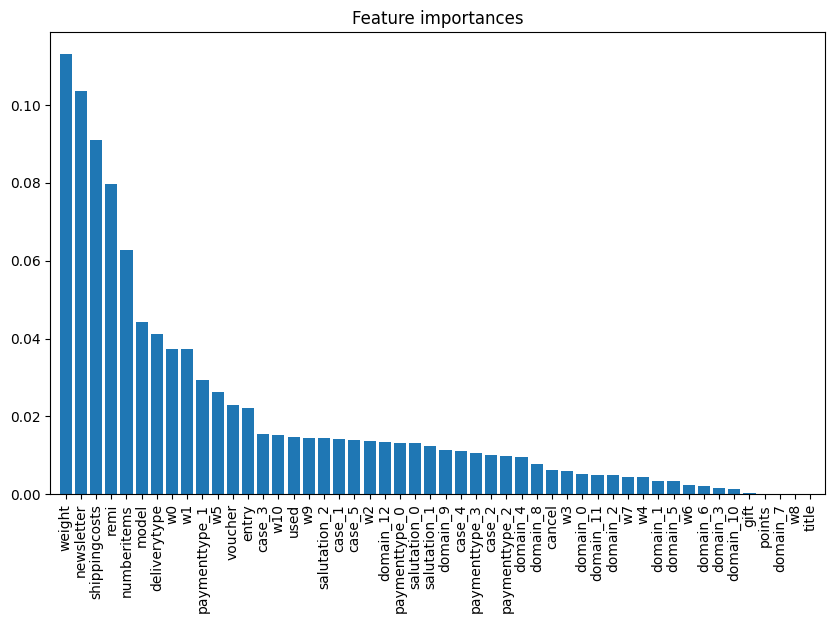

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Getting feature names
feature_names = X_train.columns.to_numpy()

# Getting feature importance
feature_importances = model_rf.feature_importances_

# Indexed arrays of feature importance sorted from largest to smallest
sorted_idx = np.argsort(feature_importances)[::-1]

# Mapping the importance of features
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx])
plt.xticks(range(X_train.shape[1]), feature_names[sorted_idx], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

weight, newsletter, shippingcosts:These characteristics play a key role in the model's prediction of customer behavior.

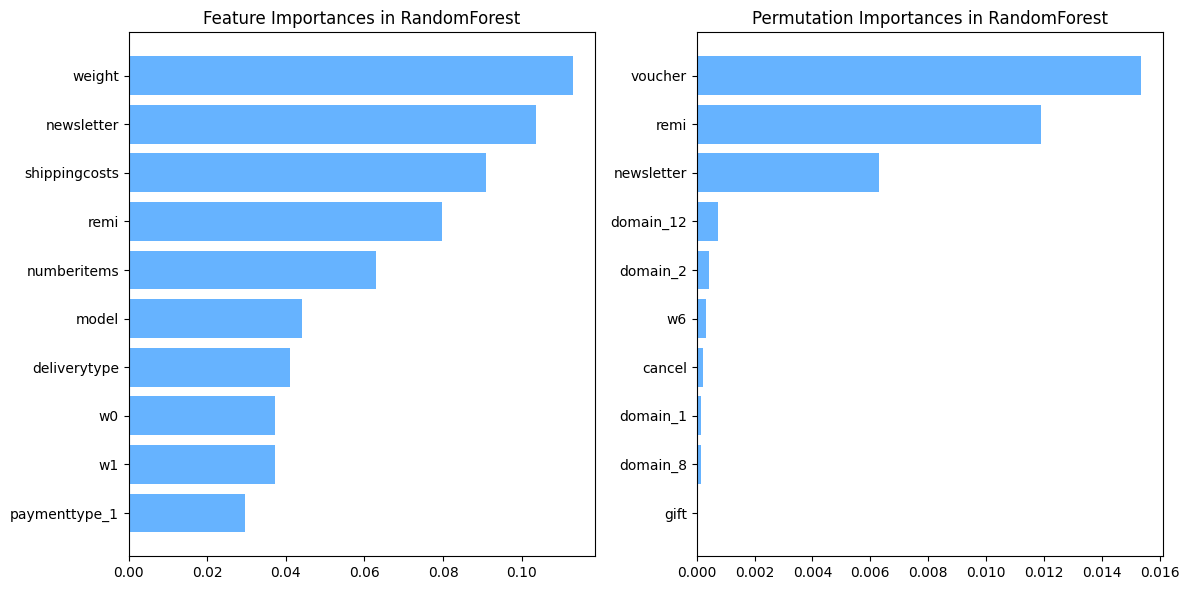

In [13]:
from sklearn.inspection import permutation_importance

# Display the first 15 features
top = 10  
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plotting the importance of random forest features
ax[0].barh(y=np.arange(top), width=feature_importances[sorted_idx[:top]], color='#0081ff', alpha=0.6)
ax[0].set_yticks(np.arange(top))
ax[0].set_yticklabels(feature_names[sorted_idx[:top]])
ax[0].invert_yaxis()  
ax[0].set_title('Feature Importances in RandomForest')

# Calculating the importance of permutation features
perm_importance = permutation_importance(model_rf, X_test, y_test, n_repeats=30, random_state=71)
sorted_idx_p = perm_importance.importances_mean.argsort()[::-1]

# Plotting the importance of permutation features
ax[1].barh(y=np.arange(top), width=perm_importance.importances_mean[sorted_idx_p[:top]], color='#0081ff', alpha=0.6)
ax[1].set_yticks(np.arange(top))
ax[1].set_yticklabels(feature_names[sorted_idx_p[:top]])
ax[1].invert_yaxis()  
ax[1].set_title('Permutation Importances in RandomForest')

plt.tight_layout()
plt.show()


On the left are the feature importance scores obtained directly from the random forest model. Permutation Importance is calculated by randomly changing the order of values for each feature and observing how the model performance changes.  
The features remi and newspaper are at the top of the importance list under both methods, so they have a significant role in the prediction of the model.

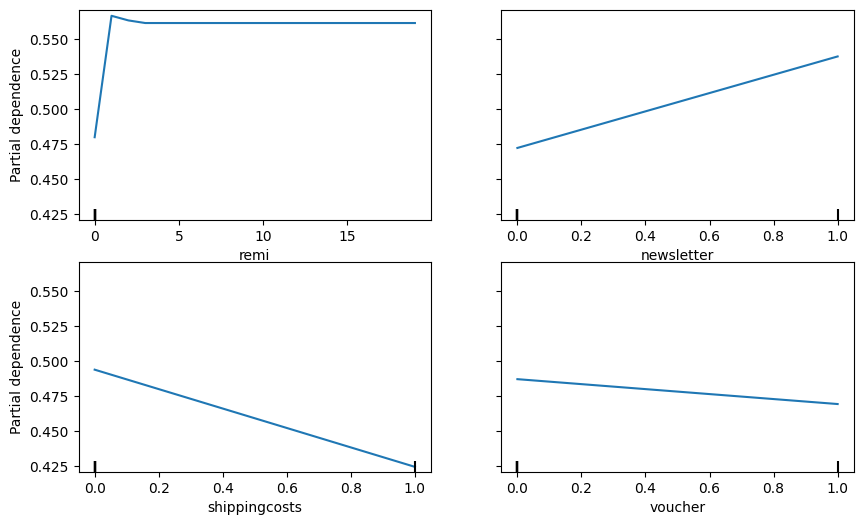

In [20]:
from sklearn.inspection import PartialDependenceDisplay as pdp

# Partial Dependence Plots
features = ['remi', 'newsletter', 'shippingcosts','voucher']  

fig, ax = plt.subplots(2,2,figsize=(10, 6))
pdp.from_estimator(model_rf, X_train, features, feature_names=feature_names, ax=ax)
plt.show()

newsletter: shows a positive slope, which could mean that newsletter subscribers are more likely to order again within 90 days.  
shippingcosts: has a negative slope, which could mean that high shipping costs may lead to a lower willingness to repurchase.  
remi indicates the number of returned items, so it could be that users find the product unsuitable and exchange it, thus increasing the probability of placing another order.

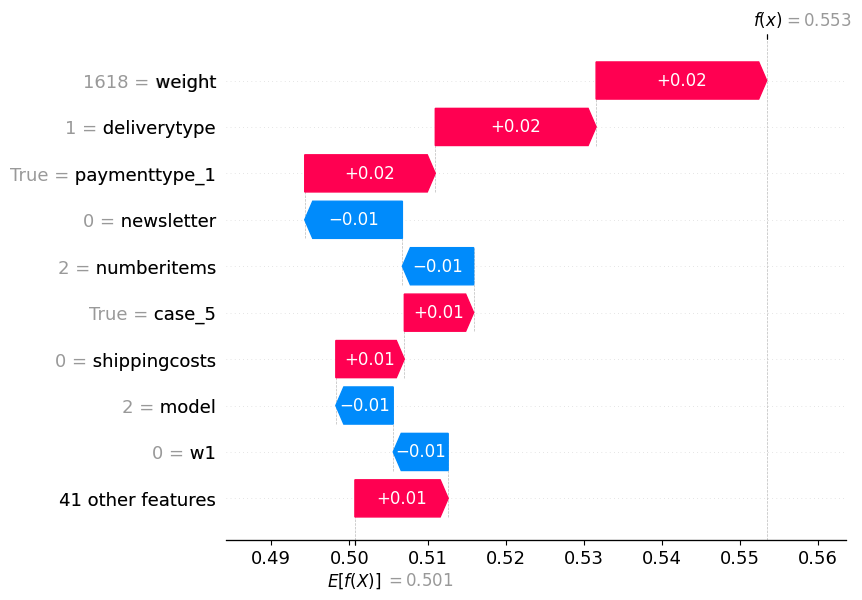

In [16]:
import shap
## Waterfall plot of SHAP values for the second row of data points
# Creating a SHAP interpreter 
explainer = shap.TreeExplainer(model_rf)

# Select a sample for interpretation
i = 1  
shap_value = explainer(X_test.iloc[i:i+1])

# Get the SHAP value corresponding to the positive class
positive_class_shap_values = shap_value.values[0,:,1]

base_value = shap_value.base_values[0,1]

# pass the SHAP value and other information to the waterfall plot
shap.plots.waterfall(shap.Explanation(values=positive_class_shap_values,
                                      base_values=base_value,
                                      data=shap_value.data[0],
                                      feature_names=X_test.columns.tolist()))


A high value of weight=1618 improves the probability that the customer will place another order.  
Deliverytype of collection improves the probability that the customer will place another order.  
No shipping cost increases the probability that the customer will place an order.   
No newspaper subscription decreases the probability of re-ordering.

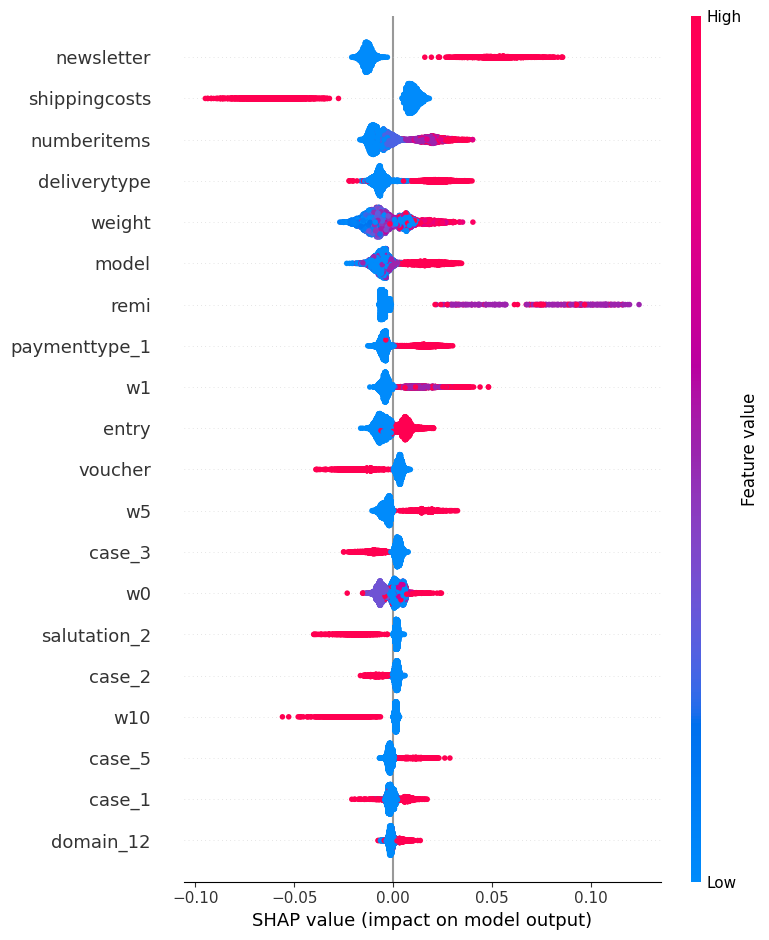

In [17]:
# Calculate SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Plot the positive SHAP values
shap.summary_plot(shap_values[1], X_test, plot_type="dot")


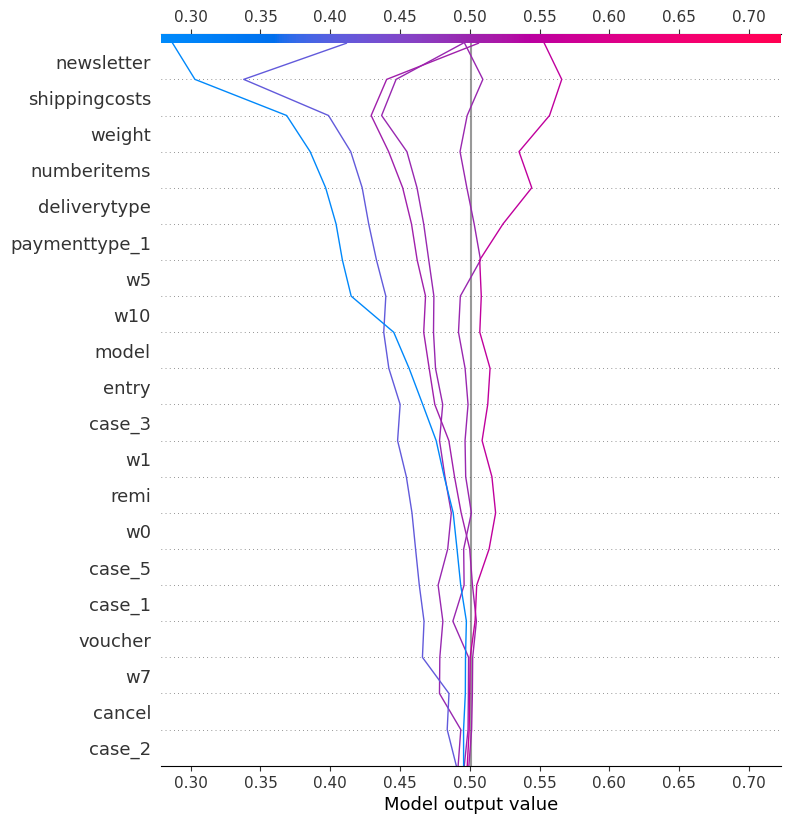

In [18]:
# Decision plot
sample_test_idx = X_test.index.get_indexer_for([1748, 29621,  2603, 12170, 20148, 18518])


expected_value = explainer.expected_value[1]
shap.decision_plot(expected_value, shap_values[1][sample_test_idx], X_test.iloc[sample_test_idx])

plt.show()

A decision plot of the shapley values for a set of data is shown, with the left-right variation of the line showing the effect of each feature on the final prediction.

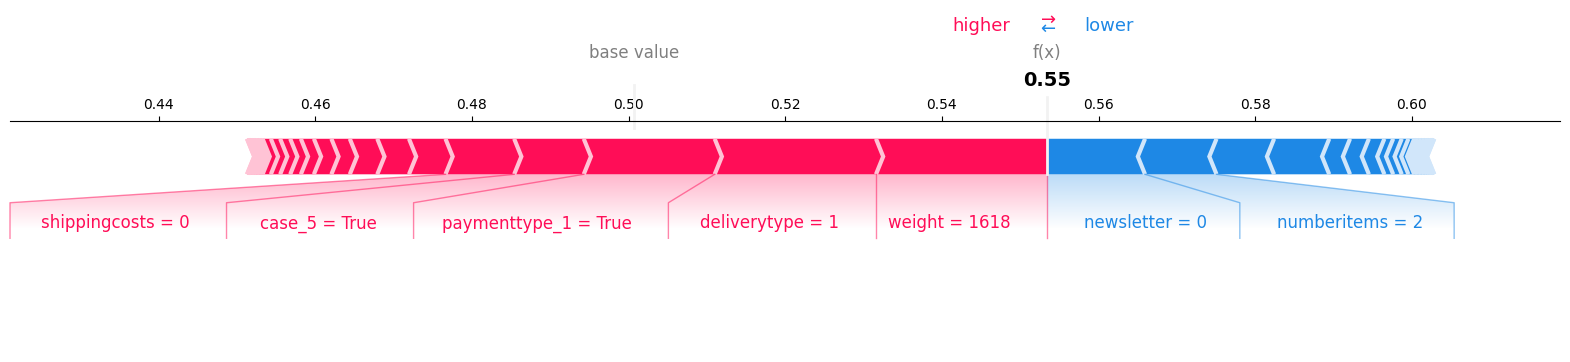

In [19]:
# Force Plot
shap.force_plot(expected_value, shap_values[1][X_test.index==18518],\
                X_test[X_test.index==18518],  matplotlib=True)

The same data points as the first waterfall plot (the waterfall plot is the data points in the second row, here the force diagram indexes the data points in 18518. This is actually the same row of data) so we can see that the results remain consistent with the first waterfall plot.